### Helper Functions and imports

In [1]:
import os
import time
import math
import json
import fnmatch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import minimize
from matplotlib.pyplot import figure

In [2]:
def sigmoid(x):
    '''
    Counts sigmoid function for x
    Arguments:
        x: float
    Returns:
        Sigmoid function value at x
    '''
    sig = 1 / (1 + math.exp(-x))
    return sig

In [3]:
def normalize_grid(data):
    '''
    Normalizes data using log function
    Arguments:
        data: float or array-like
    Returns:
        Log function value for data
    '''
    return np.log(data)

In [4]:
def get_grids_percent(e_grid_values, grid_values, rads):
    '''
    Count difference in grids in interpolation radius
    Arguments:
        e_grid_values: array-like (float)
        grid_values: array-like (float)
        rads: array-like (bool)
    Returns:
        Difference between e_grid and grid in share (to get percents multiply to 100)
    '''
    if np.sum(grid_values[rads]) == 0:
        return 1
    return np.sum(e_grid_values[rads]) / np.sum(grid_values[rads])

### Load Data

In [5]:
plast_dir = 'Case_3' # Formation Folder
normalize = False # Normalize bool variable

Found 2 fields
Processing field 1 ...


100%|██████████████████████████████████████████████████████████████████████| 360699/360699 [00:02<00:00, 160077.55it/s]


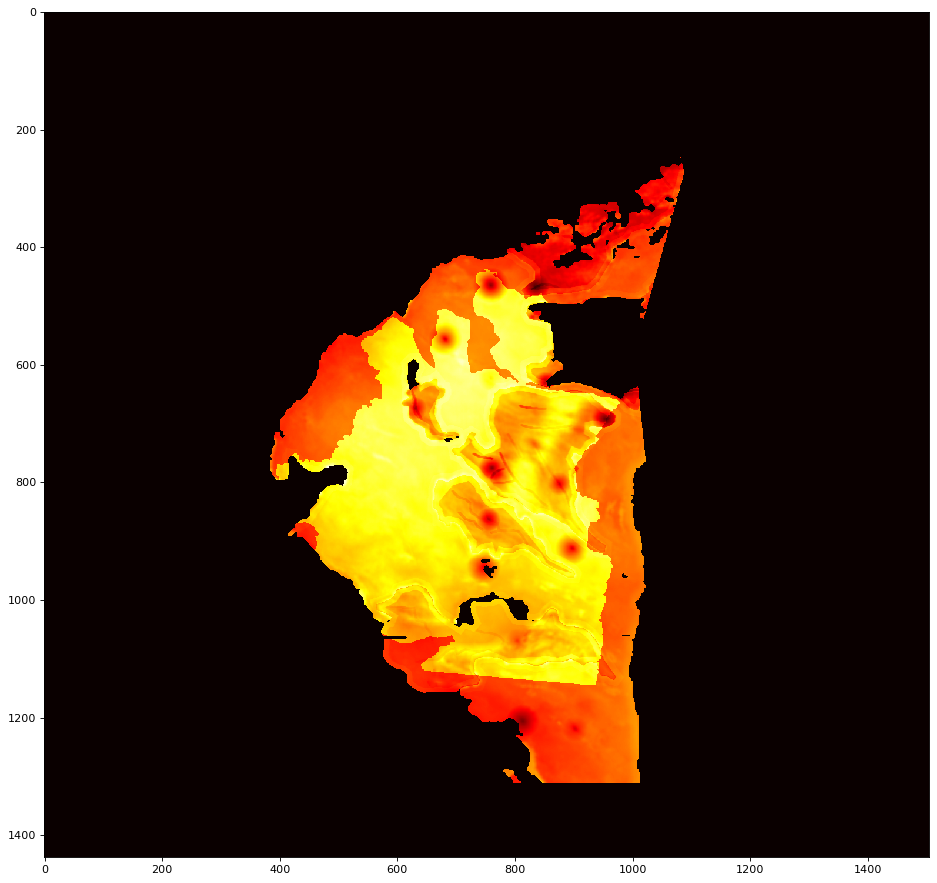

100%|██████████████████████████████████████████████████████████████████████| 360699/360699 [00:02<00:00, 165165.86it/s]


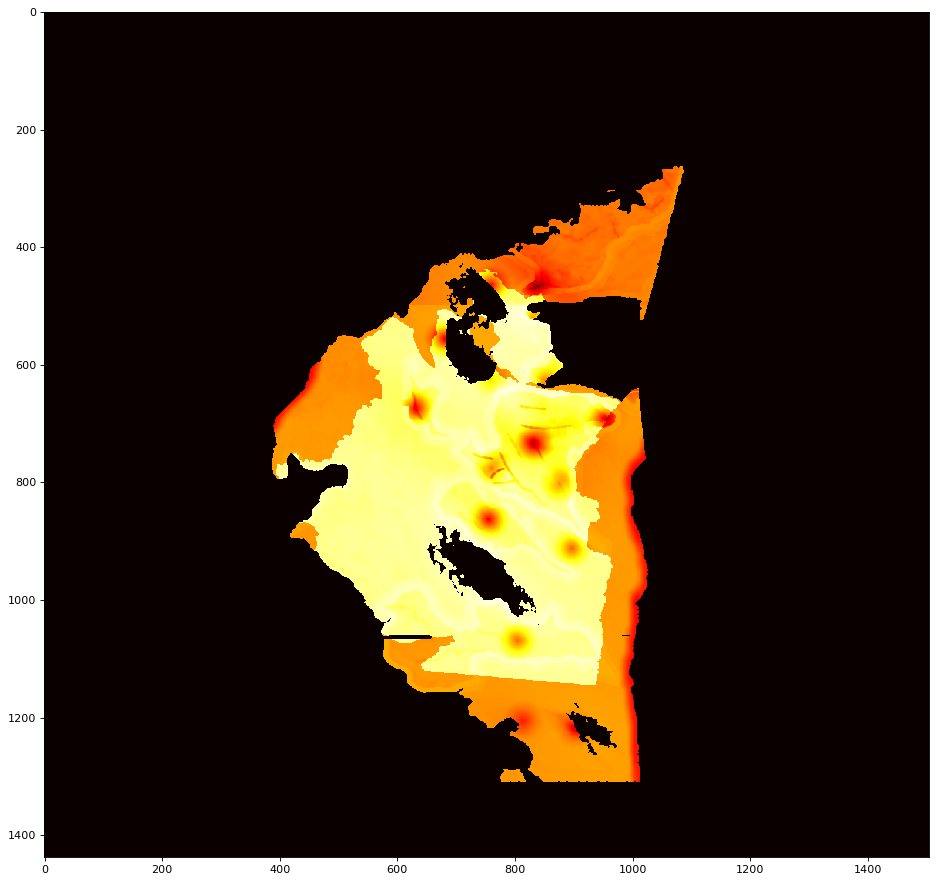

100%|██████████████████████████████████████████████████████████████████████| 360699/360699 [00:02<00:00, 167741.37it/s]


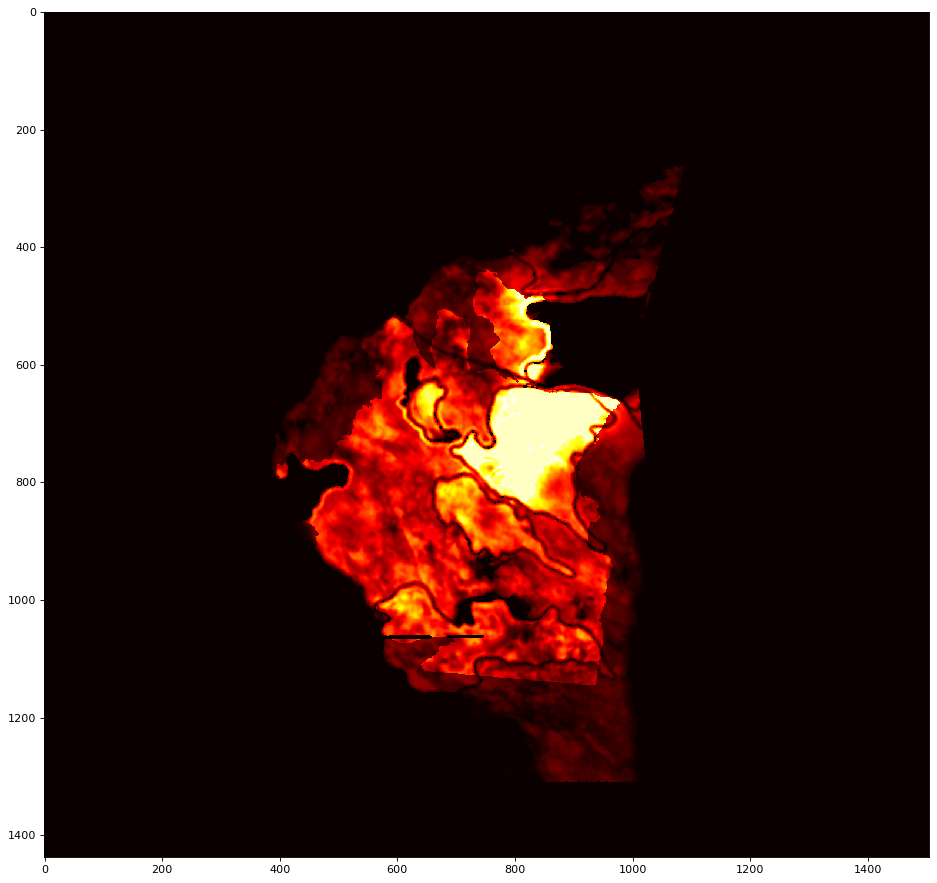

Processing field 2 ...


100%|██████████████████████████████████████████████████████████████████████| 360699/360699 [00:02<00:00, 172333.88it/s]


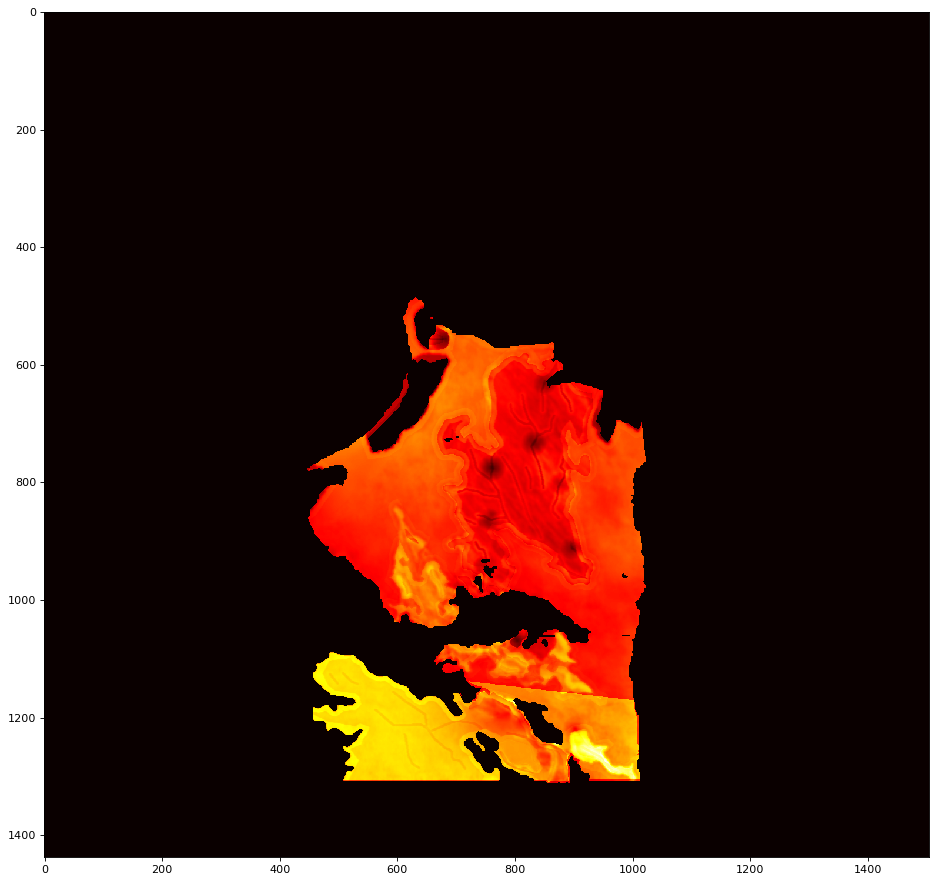

100%|██████████████████████████████████████████████████████████████████████| 360699/360699 [00:02<00:00, 171898.26it/s]


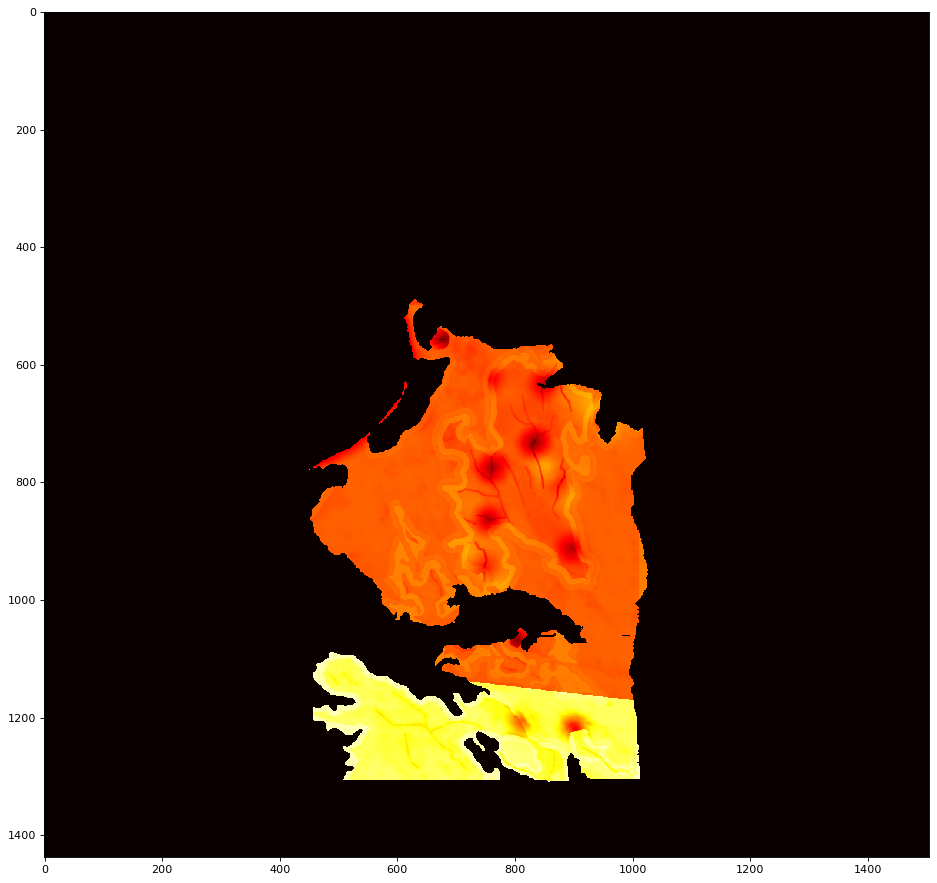

100%|██████████████████████████████████████████████████████████████████████| 360699/360699 [00:02<00:00, 175550.20it/s]


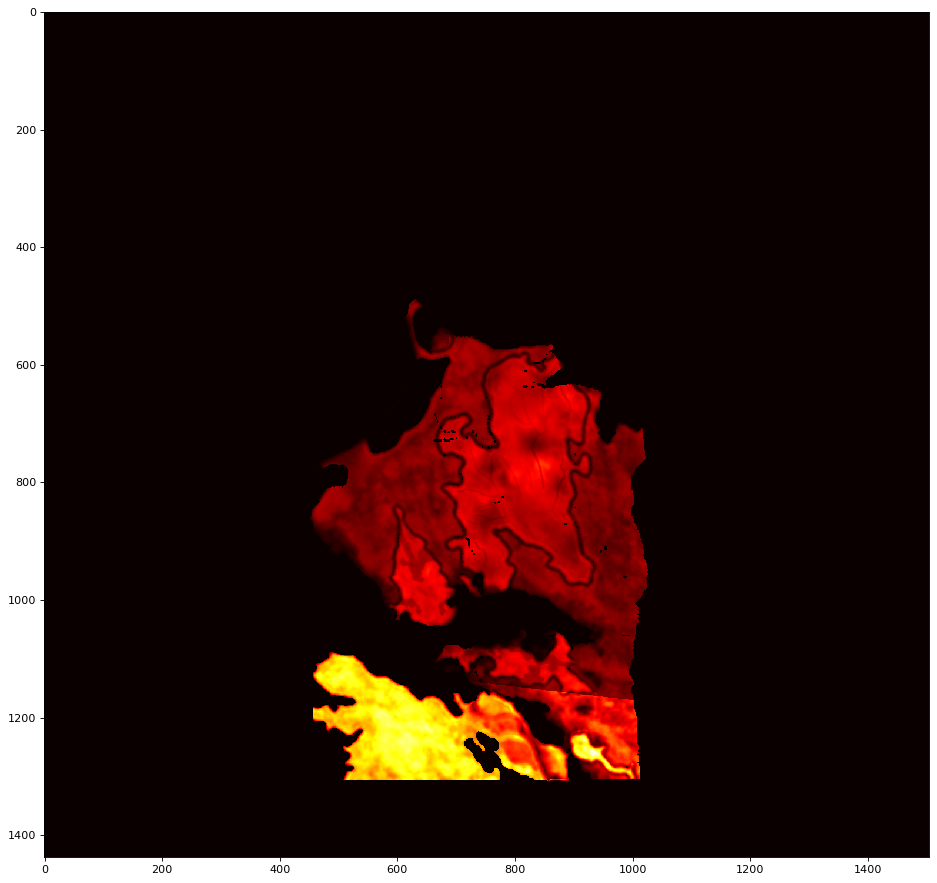

x size: 1438
y size: 1505


In [6]:
s_plast_values = [] # Saturation
p_plast_values = [] # Porosity
d_plast_values = [] # Depth (thickness)

plasts_n = len(fnmatch.filter(os.listdir(plast_dir), 'Porosity_STD_*'))
print('Found %d formations' % plasts_n)

# Reading grid data
for i in range(1, plasts_n + 1):
    print('Processing formation %d ...' % i)

    s_grid_file = open(os.path.join(plast_dir, 'Saturation_STD_%d' % i), 'r')
    p_grid_file = open(os.path.join(plast_dir, 'Porosity_STD_%d' % i), 'r')
    d_grid_file = open(os.path.join(plast_dir, 'Thickness_STD_%d' % i), 'r')
    grids = []

    for grid_file in [s_grid_file, p_grid_file, d_grid_file]:
        lines = grid_file.readlines()
        for j in range(0, len(lines)):
            lines[j] = lines[j].replace('\n', '')

        numX = int(lines[0].split(' ')[1])
        numY = int(lines[2].split(' ')[0])
        b_lines = lines[4:]

        grid_x_size = numX
        grid_y_size = numY

        grid_values = np.zeros((numX, numY))
        x_i = 0
        y_i = 0

        for l in tqdm(b_lines):
            values = l.split(' ')
            for val in values:
                if int(float(val)) != 9999900 and int(float(val)) >= 0:
                    grid_values[x_i][y_i] = float(val)

                y_i += 1
                if y_i == numY:
                    y_i = 0
                    x_i += 1

        grid_values = np.fliplr(grid_values[::-1, ::-1])
        
        figure(figsize=(16, 14), dpi=80)
        plt.imshow(grid_values, cmap='hot', interpolation='none')
        plt.show()
        
        grids.append(grid_values)

    s_grid_values = grids[0]
    p_grid_values = grids[1]
    d_grid_values = grids[2]

    if normalize:
        s_grid_values = normalize_grid(s_grid_values)
        p_grid_values = normalize_grid(p_grid_values)
        d_grid_values = normalize_grid(d_grid_values)

    s_plast_values.append(s_grid_values)
    p_plast_values.append(p_grid_values)
    d_plast_values.append(d_grid_values)

print('x size:', grid_x_size)
print('y size:', grid_y_size)

### Parameters set

In [12]:
r = 5. # radius
b_percent = 10. # percent threshold (in %)
min_plasts = 2 # minimum amount of formations
std_k = 0.5 # coefficient for std in percent values
saturation_threshold = 5
porosity_threshold = 5
depth_threshold = 5

### Robust algorithm

In [13]:
x = np.arange(0, numX) # just range for X
y = np.arange(0, numY) # and for Y

In [14]:
if min_plasts > len(p_plast_values):
    print('Minimum amount of formations set: %s, formations found: %s. Please, reduce the minimum.' % (min_plasts, len(p_plast_values)))

In [15]:
optimization_dict = {} # dictionary to store parameters

robust_well_coords = (0, 0) # saving proposed well coordinates
max_robust_percentage = 0 # saving max percentage in interpolation radius
sum_percent = 0 # saving max percentage sum in interpolation radius
optimized_zone = [] # saving optimized zone mask

p_flag = True
all_ok = False

s_optimized_plast_values = s_plast_values.copy()
p_optimized_plast_values = p_plast_values.copy()
d_optimized_plast_values = d_plast_values.copy()

b_failed_params = ['saturation', 'porosity', 'depth']

for i in tqdm(range(0, len(s_grid_values))): # iterate through lines
    for j in range(0, len(s_grid_values[i])): # and columns
        zero_count = 0
        for c in range(len(s_plast_values)): # check if formation isn't represented in this coordinate
            if s_plast_values[c][i][j] < 0.1 or p_plast_values[c][i][j] < 0.1 or d_plast_values[c][i][j] < 0.1:
                zero_count += 1

        if zero_count > plasts_n - min_plasts: # if number of zero formations > required, skip
            continue

        a_optimized_plast_values = []
        plasts_percent_sums = []
        plasts_params_percent = []

        cx = float(j)
        cy = float(i)
        mask = (y[np.newaxis, :] - cy) ** 2 + (x[:, np.newaxis] - cx) ** 2 < r ** 2 # mask for interpolation radius

        for c in range(len(s_plast_values)): # iterate through formations
            s = s_plast_values.copy()
            p = p_plast_values.copy()
            d = d_plast_values.copy()

            c_s_grid_values = s[c].copy()
            c_p_grid_values = p[c].copy()
            c_d_grid_values = d[c].copy()

            # checks if interpolation zone is not 0
            rad_flag = False
            for b in (c_s_grid_values[mask]):
                if b < 0.1:
                    rad_flag = True
                    break
            for b in (c_p_grid_values[mask]):
                if b < 0.1:
                    rad_flag = True
                    break
            for b in (c_d_grid_values[mask]):
                if b < 0.1:
                    rad_flag = True
                    break

            if rad_flag:
                continue

            # interpolation in zone (using atan)
            interp_rad = []
            for b in c_s_grid_values[mask]:
                interp_rad.append(math.atan(b))
            c_s_grid_values[mask] = interp_rad

            interp_rad = []
            for b in c_p_grid_values[mask]:
                interp_rad.append(math.atan(b))
            c_p_grid_values[mask] = interp_rad

            interp_rad = []
            for b in c_d_grid_values[mask]:
                interp_rad.append(math.atan(b))
            c_d_grid_values[mask] = interp_rad

            # setting std at coordinate as 0
            c_s_grid_values[i][j] = 0.001
            c_p_grid_values[i][j] = 0.001
            c_d_grid_values[i][j] = 0.001

            # count percents and save data to lists
            s_percent = (1 - get_grids_percent(c_s_grid_values, s[c], mask)) * 100
            p_percent = (1 - get_grids_percent(c_p_grid_values, p[c], mask)) * 100
            d_percent = (1 - get_grids_percent(c_d_grid_values, d[c], mask)) * 100

            sum_p = np.mean([s_percent, p_percent, d_percent]) - std_k * np.std([s_percent, p_percent, d_percent])
            plasts_percent_sums.append(sum_p)
            plasts_params_percent.append([s_percent, p_percent, d_percent])

            a_optimized_plast_values.append([c_s_grid_values, c_p_grid_values, c_d_grid_values])

        sum_p_plast = np.mean(plasts_percent_sums)

        # properties threshold
        saturation_val = np.mean([x[0] for x in plasts_params_percent])
        porosity_val = np.mean([x[1] for x in plasts_params_percent])
        depth_val = np.mean([x[2] for x in plasts_params_percent])

        # sum of all %s in formations > threshold and > previous sum
        if (sum_p_plast >= b_percent and sum_percent < sum_p_plast and len(a_optimized_plast_values) >= min_plasts):
            failed_params = []
            if saturation_threshold > saturation_val:
                failed_params.append('saturation')
            if porosity_threshold > porosity_val:
                failed_params.append('porosity')
            if depth_threshold > depth_val:
                failed_params.append('depth')

            # check if it doesn't pass threshold for any property
            if len(failed_params) > 0:
                if len(b_failed_params) >= len(failed_params):
                    b_failed_params = failed_params
            else:
                if len(b_failed_params) >= len(failed_params):
                    b_failed_params = failed_params

                # save the data for output
                for c in range(len(a_optimized_plast_values)):
                    s_optimized_plast_values[c] = a_optimized_plast_values[c][0].copy()
                    p_optimized_plast_values[c] = a_optimized_plast_values[c][1].copy()
                    d_optimized_plast_values[c] = a_optimized_plast_values[c][2].copy()

                robust_well_coords = (i, j)

                p_flag = False
                all_ok = True
                optimized_zone = mask
                sum_percent = sum_p
        elif all_ok: # in case we already found zone with all 3 properties suitable
            continue
        elif sum_p_plast >= b_percent and len(a_optimized_plast_values) >= min_plasts: # if we didn't do that, but passed the threshold
            temp_grids = [s_plast_values, s_plast_values, s_plast_values]

            if max([x[0] for x in plasts_params_percent]) >= b_percent:
                temp_grids[0] = [x[0] for x in a_optimized_plast_values]
                p_flag = False
                optimized_zone = mask

            if max([x[1] for x in plasts_params_percent]) >= b_percent:
                temp_grids[1] = [x[1] for x in a_optimized_plast_values]
                p_flag = False
                optimized_zone = mask

            if max([x[2] for x in plasts_params_percent]) >= b_percent:
                temp_grids[2] = [x[2] for x in a_optimized_plast_values]
                p_flag = False
                optimized_zone = mask

            s_optimized_plast_values = temp_grids[0]
            p_optimized_plast_values = temp_grids[1]
            d_optimized_plast_values = temp_grids[2]

            robust_well_coords = (i, j)
            max_robust_percentage = max(max_robust_percentage, sum_p_plast)

        # saving data to dict
        optimization_dict[(i, j)] = {'saturation': saturation_val,
                                     'porosity': porosity_val,
                                     'depth': depth_val,
                                     'coeff': sum_p_plast}

 44%|█████████████████████████████████▊                                           | 632/1438 [13:27<2:52:31, 12.84s/it]C:\Users\rgarc\anaconda3\envs\voma\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rgarc\anaconda3\envs\voma\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████| 1438/1438 [4:30:47<00:00, 11.30s/it]


In [25]:
if p_flag: # didn't find suitable zone for threshold
    print('Threshold percentage set:', b_percent)
    print('Largest decrease in percent:', max_robust_percentage)
    print('Please, reduce the threshold')

In [26]:
if len(b_failed_params) > 0: # didn't find suitable zone for properties threshold
    print('Optimization did not pass the threshold for these parameters:')
    for p in b_failed_params:
        print(p)
else:
    print('Optimization complete. Proposed well coordinates is', robust_well_coords)

Optimization complete. Proposed well coordinates is (996, 914)


In [29]:
print('OPTIMIZED (in optimized zone)')
for i in range(len(s_plast_values)):
    print('Formation %i:' % i)
    
    s_grid_values = s_plast_values[i]
    p_grid_values = p_plast_values[i]
    d_grid_values = d_plast_values[i]
    
    s_optimized_grid_values = s_optimized_plast_values[i]
    p_optimized_grid_values = p_optimized_plast_values[i]
    d_optimized_grid_values = d_optimized_plast_values[i]
    
    print('d_saturation:', np.sum(s_grid_values[optimized_zone]) - np.sum(s_optimized_grid_values[optimized_zone]))
    print('d_porosity:', np.sum(p_grid_values[optimized_zone]) - np.sum(p_optimized_grid_values[optimized_zone]))
    print('d_depth:', np.sum(d_grid_values[optimized_zone]) - np.sum(d_optimized_grid_values[optimized_zone]))
    print('d_all:', np.sum(s_grid_values[optimized_zone]) + np.sum(p_grid_values[optimized_zone]) + np.sum(d_grid_values[optimized_zone]) - np.sum(s_optimized_grid_values[optimized_zone]) - np.sum(p_optimized_grid_values[optimized_zone]) - np.sum(d_optimized_grid_values[optimized_zone]))
    print('%saturation:', (1-(np.sum(s_optimized_grid_values[optimized_zone]) / np.sum(s_grid_values[optimized_zone])))*100)
    print('%porosity:', (1-(np.sum(p_optimized_grid_values[optimized_zone]) / np.sum(p_grid_values[optimized_zone])))*100)
    print('%depth:', (1-(np.sum(d_optimized_grid_values[optimized_zone]) / np.sum(d_grid_values[optimized_zone])))*100)
    print('%all:', (1 - (np.sum(s_optimized_grid_values[optimized_zone]) + np.sum(p_optimized_grid_values[optimized_zone]) + np.sum(d_optimized_grid_values[optimized_zone])) / (np.sum(s_grid_values[optimized_zone]) + np.sum(p_grid_values[optimized_zone]) + np.sum(d_grid_values[optimized_zone])))*100)
    print("-----------------------------------------")

OPTIMIZED (in optimized zone)
Formation 0:
d_saturation: 444.4801069462643
d_porosity: 42.3321381814946
d_depth: 48.33056077070273
d_all: 535.1428058984617
%saturation: 81.68154994935276
%porosity: 37.511636665499495
%depth: 40.002182068222844
%all: 68.79921869398105
-----------------------------------------
Formation 1:
d_saturation: 456.24020035818825
d_porosity: 31.563794531925595
d_depth: 91.59987998349189
d_all: 579.4038748736057
%saturation: 82.04175844157169
%porosity: 32.39633099610232
%depth: 52.71222474946002
%all: 70.03459545345598
-----------------------------------------


In [27]:
# print the statistic
max_saturation = 0
max_porosity = 0
max_depth = 0

for val in optimization_dict.values():
    if max_saturation < val['saturation']:
        max_saturation = val['saturation']

    if max_porosity < val['porosity']:
        max_porosity = val['porosity']

    if max_depth < val['depth']:
        max_depth = val['depth']

print('Max grid properties %:')
print('Saturation: %d' % int(max_saturation))
print('Porosity: %d' % int(max_porosity))
print('Depth: %d' % int(max_depth))

Max grid properties %:
Saturation: 87
Porosity: 51
Depth: 85


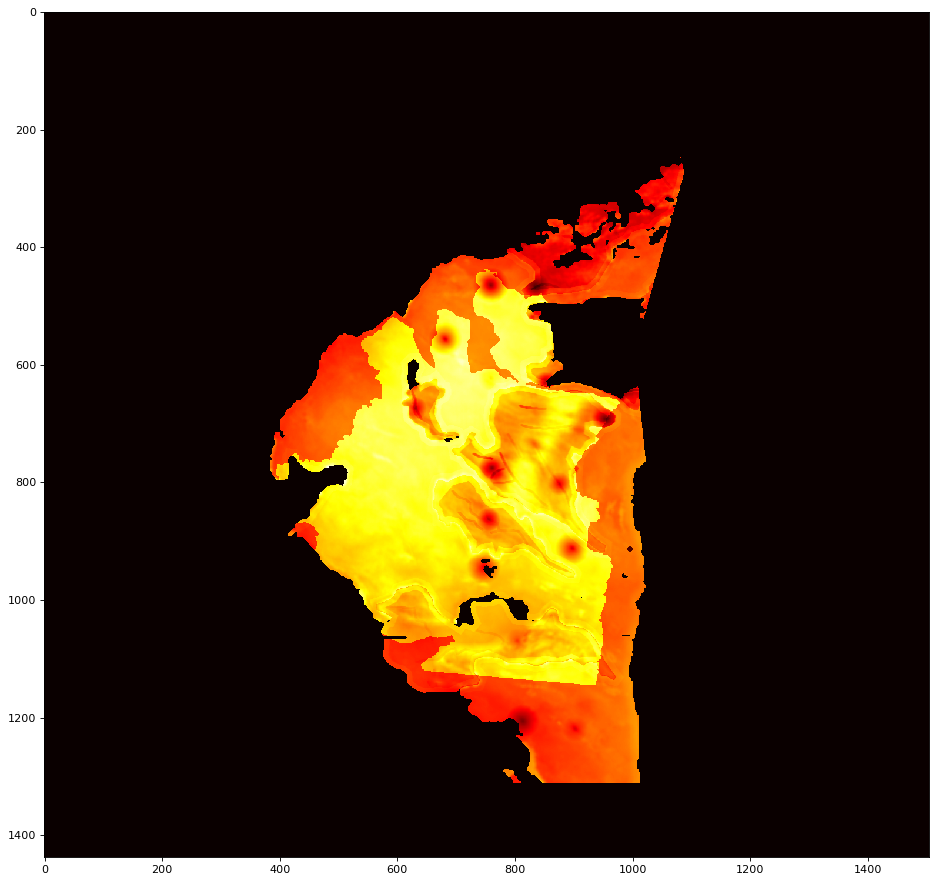

In [30]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(s_optimized_plast_values[0]), cmap='hot', interpolation='none')
plt.show()

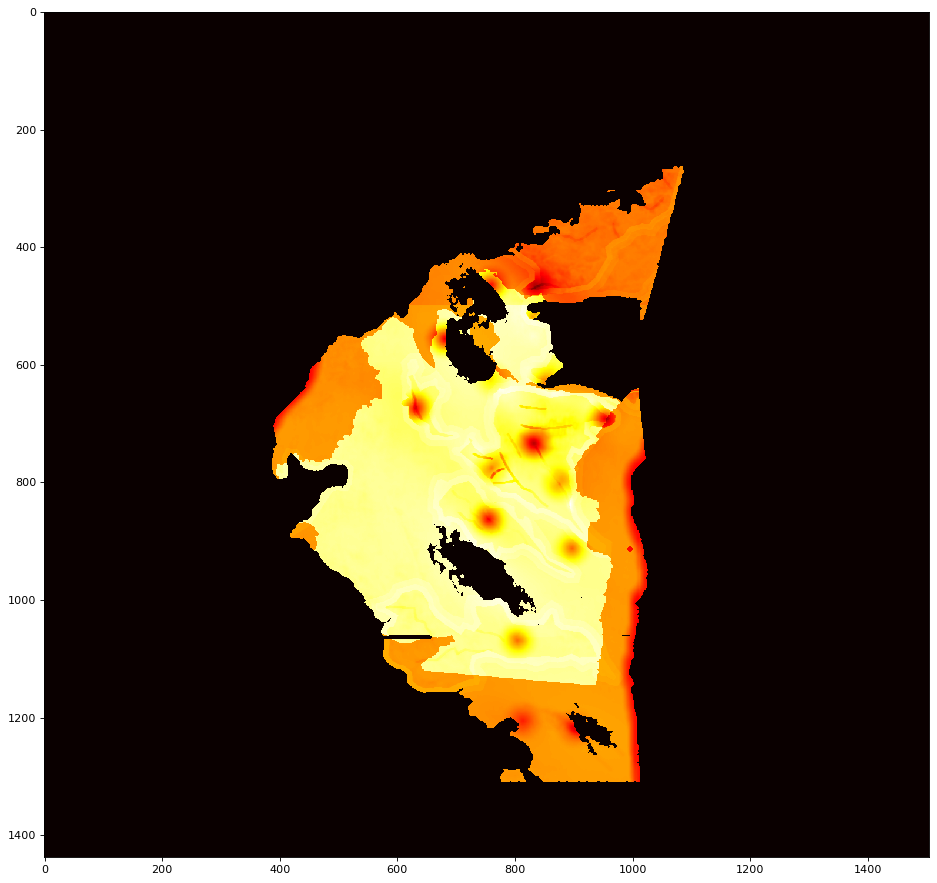

In [31]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(p_optimized_plast_values[0]), cmap='hot', interpolation='none')
plt.show()

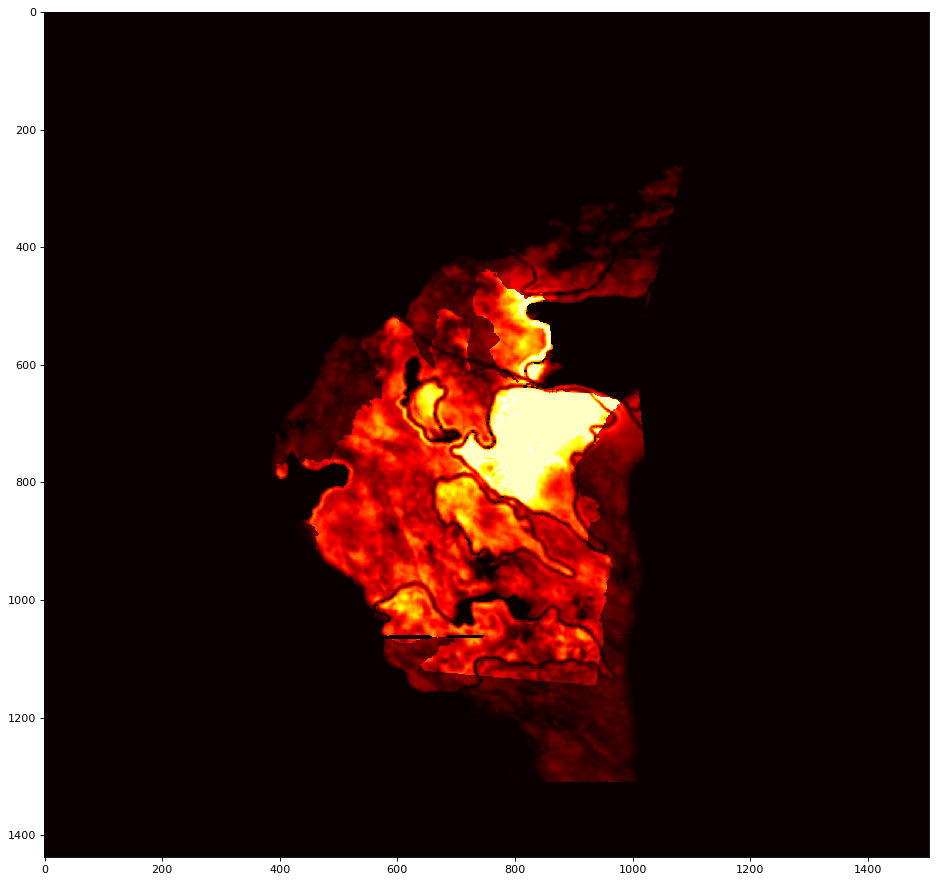

In [32]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(d_optimized_plast_values[0]), cmap='hot', interpolation='none')
plt.show()

In [33]:
# saving data in output files
for i in range(1, plasts_n+1):
    files = ['Saturation_zone_%d'%i, 'Porosity_zone_%d'%i, 'Depth_zone_%d'%i]
    j = 0
    for optimized_grid_values in [s_optimized_plast_values[i-1], p_optimized_plast_values[i-1], d_optimized_plast_values[i-1]]:
        optimized_grid_values = np.fliplr(optimized_grid_values[::-1,::-1])
        p_lines = []
        p_lines.append(lines[0])
        p_lines.append(lines[1])
        p_lines.append(lines[2])
        p_lines.append(lines[3])

        s = ''
        b = 0
        for v in tqdm(optimized_grid_values):
            for x in v:
                b += 1
                if x == 0.0:
                    x = 9999900.000000
                s += str(x)
                if b >= 6:
                    b = 0
                    p_lines.append(s)
                    s = ''
                else:
                    s += ' '
        print(len(p_lines) == len(lines))

        filename = files[j]

        print('Saving', filename, '...')
        with open(filename, 'a') as f:
            for l in p_lines:
                f.write(l+'\n')

        j += 1

100%|█████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:02<00:00, 606.79it/s]


False
Saving Saturation_zone_1 ...


100%|█████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:02<00:00, 604.47it/s]


False
Saving Porosity_zone_1 ...


100%|█████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:02<00:00, 621.16it/s]


False
Saving Depth_zone_1 ...


100%|█████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:02<00:00, 618.00it/s]


False
Saving Saturation_zone_2 ...


100%|█████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:02<00:00, 620.55it/s]


False
Saving Porosity_zone_2 ...


100%|█████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:02<00:00, 583.31it/s]


False
Saving Depth_zone_2 ...
